In [1]:
# pip install git+https://github.com/AutoViML/featurewiz.git

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from typing import Tuple, List, Dict

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline


# read data
in_kaggle = False


def get_data_file_path(is_in_kaggle: bool) -> Tuple[str, str, str]:
    train_path = ''
    test_path = ''
    sample_submission_path = ''

    if is_in_kaggle:
        # running in Kaggle, inside the competition
        train_path = '../input/tabular-playground-series-jan-2021/train.csv'
        test_path = '../input/tabular-playground-series-jan-2021/test.csv'
        sample_submission_path = '../input/tabular-playground-series-jan-2021/sample_submission.csv'
    else:
        # running locally
        train_path = 'data/train.csv'
        test_path = 'data/test.csv'
        sample_submission_path = 'data/sample_submission.csv'

    return train_path, test_path, sample_submission_path

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
# main flow
start_time = dt.datetime.now()
print("Started at ", start_time)

Started at  2021-01-16 22:31:22.867196


In [4]:
%%time
# get the training set and labels
train_set_path, test_set_path, sample_subm_path = get_data_file_path(in_kaggle)

df_train = pd.read_csv(train_set_path)
df_test = pd.read_csv(test_set_path)

subm = pd.read_csv(sample_subm_path)

# list of feature columns
feature_list = [col for col in df_train.columns if col.startswith('cont')]

Wall time: 1.16 s


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
 3   cont3   300000 non-null  float64
 4   cont4   300000 non-null  float64
 5   cont5   300000 non-null  float64
 6   cont6   300000 non-null  float64
 7   cont7   300000 non-null  float64
 8   cont8   300000 non-null  float64
 9   cont9   300000 non-null  float64
 10  cont10  300000 non-null  float64
 11  cont11  300000 non-null  float64
 12  cont12  300000 non-null  float64
 13  cont13  300000 non-null  float64
 14  cont14  300000 non-null  float64
 15  target  300000 non-null  float64
dtypes: float64(15), int64(1)
memory usage: 36.6 MB


In [6]:
# Additional feature engineering routines

# Function to extract common stats features
def add_stat_features(
    train: pd.DataFrame, 
    test: pd.DataFrame, 
    features_c: List[str]) -> [pd.DataFrame, pd.DataFrame]:
    
    for df in [train, test]:
        df['c_sum'] = df[features_c].sum(axis=1)
        df['c_mean'] = df[features_c].mean(axis=1)
        df['c_std'] = df[features_c].std(axis=1)
        df['c_kurt'] = df[features_c].kurtosis(axis=1)
        df['c_skew'] = df[features_c].skew(axis=1)

    return train, test

# function to add squared c-features
def add_squared(
    train: pd.DataFrame, 
    test: pd.DataFrame, 
    features_c: List[str]) -> [pd.DataFrame, pd.DataFrame]:
    
    for df in [train, test]:
        for feature in features_c:
            df[f'{feature}_squared'] = df[feature] ** 2
    return train, test

# function to add simple genetic features
def add_genetic_features(
    train: pd.DataFrame, 
    test: pd.DataFrame, 
    features_c: List[str],
    add_plus_features=True,
    add_minus_features=False,
    add_product_features=False,
    add_divided_features=False,
    add_plus_by_minus_features=False,
    add_plus_div_by_minus_features=False
) -> [pd.DataFrame, pd.DataFrame]:
    
    small_val = 0.00001
    for df in [train, test]:
        for col1 in features_c:
            for col2 in features_c:
                if col1 != col2:
                    if add_plus_features:
                        df[f'{col1}_plus_{col2}'] = df[col1] + df[col2]
                    if add_minus_features:
                        df[f'{col1}_minus_{col2}'] = df[col1] - df[col2]
                    if add_product_features:
                        df[f'{col1}_prod_{col2}'] = df[col1] * df[col2]
                    if add_divided_features:
                        df[f'{col1}_div_{col2}'] = df[col1] / ( df[col2] + small_val)
                    if add_plus_by_minus_features:
                        df[f'{col1}_qq_{col2}'] = (df[col1] + df[col2]) * (df[col1] - df[col2])
                    if add_plus_div_by_minus_features:
                        df[f'{col1}_div2_{col2}'] = (df[col1] - df[col2]) / (df[col1] + df[col2] + small_val)

    return train, test

In [7]:
%%time

# run additional feature engineering
df_train, df_test = add_stat_features(df_train, df_test, feature_list)
df_train, df_test = add_squared(df_train, df_test, feature_list)

# df_train, df_test = add_genetic_features(df_train, df_test, feature_list)

Wall time: 1.43 s


Imported featurewiz: Auto_ViML's feature engg and selection library. Version=0.0.14
output = featurewiz(dataname, target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data='',
                    feature_engg='', category_encoders='')
Let featurewiz add features to your data! Set 'feature_engg' as: 'interactions' or 'groupby' or 'target'
                                
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
Shape of your Data Set loaded: (300000, 35)
    No GPU active on this device
    Running XGBoost using CPU parameters
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    34 Predictors classified...
        1 variable(s) removed since they were ID or low-information variables
#### Single_Label Regression Feature Selection Started ####
Searching for highly correlated variables from 33 variables u

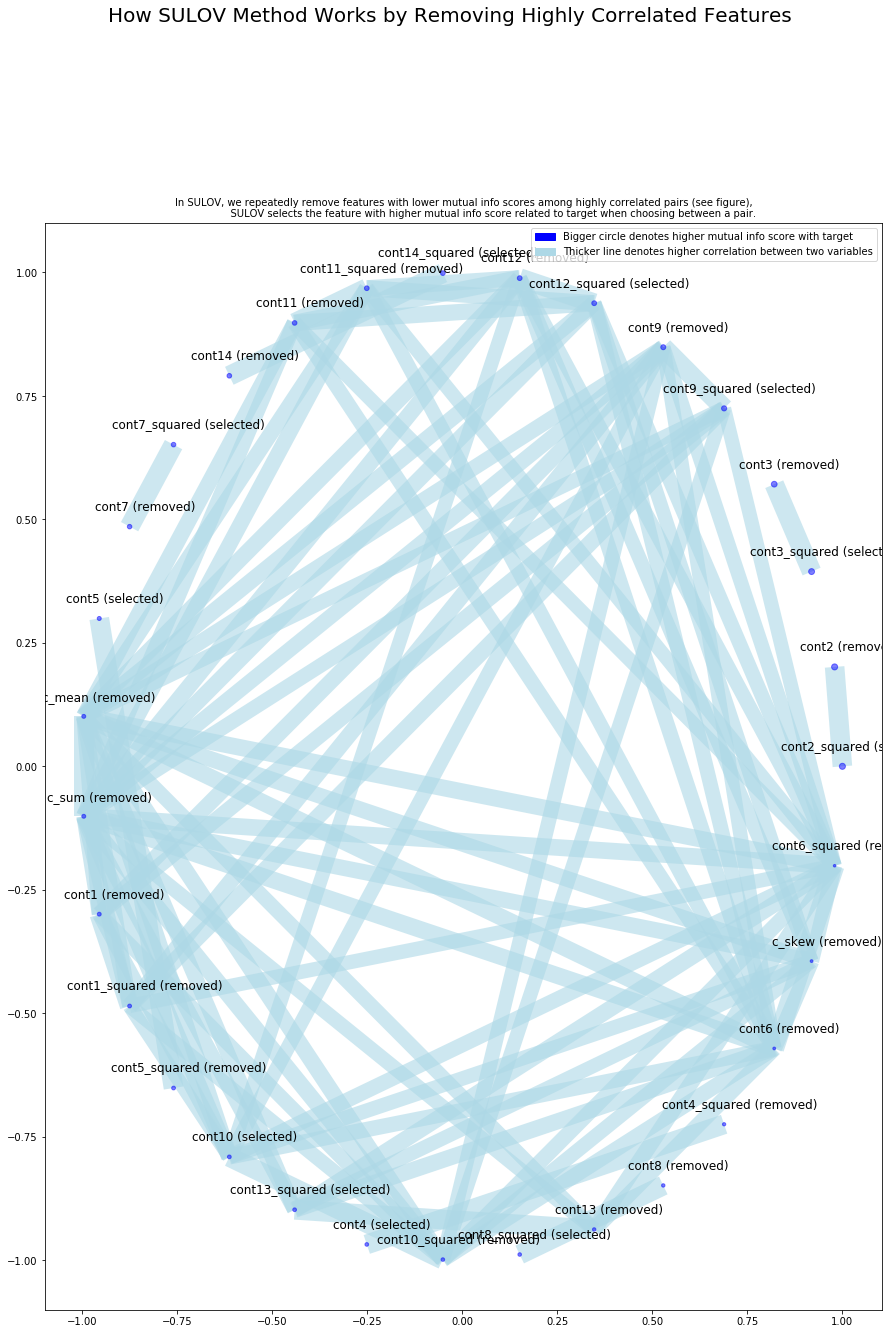

    Adding 0 categorical variables to reduced numeric variables  of 13
############## F E A T U R E   S E L E C T I O N  ####################
Current number of predictors = 13 
    Finding Important Features using Boosted Trees algorithm...
        using 13 variables...
        using 10 variables...
        using 7 variables...
        using 4 variables...
        using 1 variables...
Selected 11 important features from your dataset
    Time taken (in seconds) = 795
Returning list of 11 important features and dataframe.


In [8]:
# do feature selection with featurewiz

from featurewiz import featurewiz

df_train_out, df_test_out = featurewiz(
    dataname=df_train, 
    target='target', 
    corr_limit=0.7, 
    verbose=0, 
    sep=",",
    header=0,
    test_data=df_test, 
    feature_engg="", 
    category_encoders="")

As a result, we can see the following feature choices made by *featurewiz*

- Removed (20) highly correlated variables: 'cont1', 'cont2', 'cont3', 'cont6', 'cont7', 'cont8', 'cont9', 'cont11', 'cont12', 'cont13', 'cont14', 'c_sum', 'c_mean', 'c_skew', 'cont1_squared', 'cont4_squared', 'cont5_squared', 'cont6_squared', 'cont10_squared', 'cont11_squared'
- Selected (13) vars: 'c_std', 'c_kurt', 'cont2_squared', 'cont3_squared', 'cont9_squared', 'cont12_squared', 'cont14_squared', 'cont7_squared', 'cont5', 'cont10', 'cont13_squared', 'cont4', 'cont8_squared'

In [10]:
print('We are done. That is all, folks!')
finish_time = dt.datetime.now()
print("Finished at ", finish_time)
elapsed = finish_time - start_time
print("Elapsed time: ", elapsed)

We are done. That is all, folks!
Finished at  2021-01-16 22:46:07.832739
Elapsed time:  0:14:44.965543
